In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate

In [5]:
srcdir = "../../../data/eval/miniwob/231119_llama13b/"
metric = 'success'

In [ ]:
dfs = []

for filename in os.listdir(srcdir):
    if filename.endswith(".csv"):
        filepath = os.path.join(srcdir, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)

df_file = pd.concat(dfs, ignore_index=True)
df = df_file

df['success'] = df['success'].apply(lambda x: float(eval(x)) if isinstance(x, str) else float(x))
print(len(df))
df.head(5)

In [ ]:
# Overwrite row with best metric val from concatenated dataframe

df_group = df.groupby(['task', 'seed', 'policy'])

max_metric = df_group[metric].max()
df = df_group.first().reset_index()
df[metric] = max_metric.values

# Filter the DataFrame by a specific policy value
filtered_df = df[df['policy'] == 'paw_zeroshot']
# Tally the count for each unique task for the given policy value
task_tally = filtered_df['task'].value_counts()
# Print the result
print(task_tally)

In [8]:
tasks = task_tally.index.values.tolist()
tasks

['click-button',
 'click-button-sequence',
 'click-collapsible',
 'click-dialog',
 'click-dialog-2',
 'click-tab',
 'click-test',
 'click-test-2',
 'enter-text',
 'enter-text-2']

In [9]:
import pandas as pd

metrics =  ['success', 'num_actions']
policies = ['flat_zeroshot', 'paw_zeroshot']
table_columns = ['flat_zeroshot_success', 'flat_zeroshot_num_actions', 'paw_zeroshot_success', 'paw_zeroshot_num_actions']

mean_table = pd.DataFrame()
error_table = pd.DataFrame()
max_seed = 10
zero_offset = 0.0


for metric in metrics:
    df_sub = df[df['policy'].isin(policies)] if policies is not None else df
    df_sub = df_sub[df_sub['task'].isin(tasks)] if tasks is not None else df_sub

    # Group the filtered DataFrame by 'policy' and 'task' and calculate the average metric
    df_group = df_sub.groupby(['policy', 'task'])[metric].mean().reset_index()
    df_group_se = df_sub.groupby(['policy', 'task'])[metric].sem().reset_index()
    
    pivot_table = df_group.pivot(index='task', columns='policy', values=metric)
    pivot_table[pivot_table == 0] = zero_offset
    pivot_table = (pivot_table * max_seed).astype(int) / max_seed
    
    pivot_table_se = df_group_se.pivot(index='task', columns='policy', values=metric)


    # Rename the columns to include the metric
    pivot_table.columns = [f'{col}_{metric}' for col in pivot_table.columns]

    if mean_table.empty:
        mean_table = pivot_table
    else:
        mean_table = pd.concat([mean_table, pivot_table], axis=1)
        
    # Rename the columns to include the metric
    pivot_table_se.columns = [f'{col}_{metric}' for col in pivot_table_se.columns]

    if error_table.empty:
        error_table = pivot_table_se
    else:
        error_table = pd.concat([error_table, pivot_table_se], axis=1)

mean_table = mean_table[table_columns]
mean_table = mean_table.reindex(tasks)

error_table = error_table[table_columns]
error_table = error_table.reindex(tasks)

# Print table in a LaTeX format with two decimal places
# print(combined_table.to_latex(index=True, float_format="%.2f"))

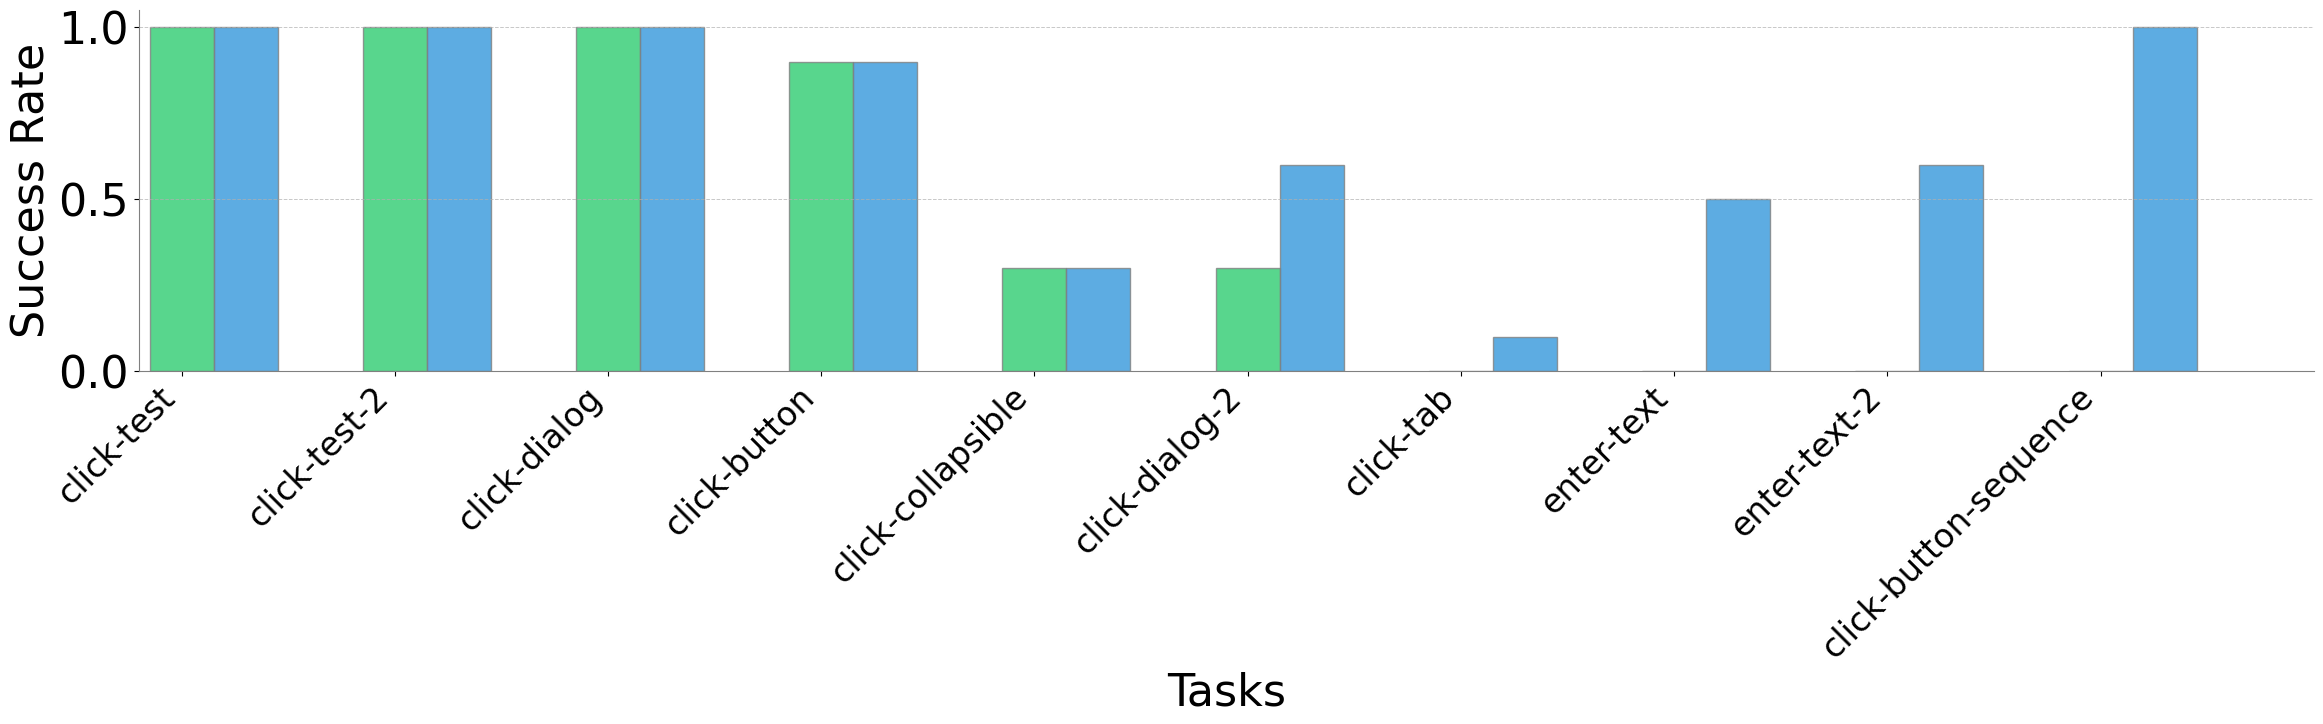

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 8))
fontsize_plots = 32
plt.rcParams.update({'font.size': fontsize_plots})
bar_width = 0.3

index = range(len(mean_table))

## Compute the difference between "paw_fewshot" and "flat_fewshot" success rates
# mean_table['difference'] = mean_table['paw_fewshot_success'] - mean_table['flat_fewshot_success']
# mean_table_sorted = mean_table.sort_values(by=['difference', 'paw_fewshot_success', 'flat_fewshot_success'], ascending=[True, False, False])
# sorted_tasks = mean_table_sorted.index.tolist()

sorted_tasks = tasks
sorted_tasks = ['click-test',
 'click-test-2',
 'click-dialog',
  'click-button',
   'click-collapsible',
    'click-dialog-2',
 'click-tab',
 'enter-text',
 'enter-text-2',
  'click-button-sequence']

#['click-link', 'click-option', 'focus-text', 'click-button', 'click-button-sequence', 'click-dialog', 'click-dialog-2', 'click-tab', 'click-test', 'click-test-2', 'enter-text', 'focus-text-2', 'enter-text-dynamic', 'enter-password', 'login-user', 'click-pie', 'enter-date', 'grid-coordinate',  'click-widget', 'email-inbox', 'email-inbox-nl-turk', 'email-inbox-forward-nl-turk', 'multi-orderings', 'choose-date', 'click-collapsible-2', 'simple-arithmetic', 'click-tab-2', 'click-tab-2-hard', 'multi-layouts', 'copy-paste', 'click-collapsible', 'choose-date-easy', 'copy-paste-2', 'simple-algebra', 'click-checkboxes', 'click-checkboxes-transfer', 'login-user-popup', 'click-checkboxes-soft', 'enter-text-2', 'email-inbox-forward-nl', 'search-engine', 'find-word', 'choose-date-medium', 'click-checkboxes-large', 'book-flight']

mean_table_sorted = mean_table.loc[sorted_tasks]

# Plotting bars for both columns with gradient shading
plt.bar(index, mean_table_sorted['flat_zeroshot_success'], bar_width, label='flat_zeroshot', color='#2ecc71', alpha=0.8, edgecolor='gray')
plt.bar([i + bar_width for i in index], mean_table_sorted['paw_zeroshot_success'], bar_width, label='paw_zeroshot', color='#3498db', alpha=0.8, edgecolor='gray')

# Setting the x axis labels with bold font and adjusted positions
plt.xlabel('Tasks')
plt.ylabel('Success Rate', fontsize=fontsize_plots)
plt.xlim(-0.2, max(index) + 1)
plt.yticks(fontsize=fontsize_plots)
plt.xticks(index, mean_table_sorted.index, rotation=45, ha="right", fontsize=fontsize_plots-8)  # Adjusted tick positions and alignment
# plt.legend()

# Setting the grid and background color
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.gca().set_facecolor('white')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color('gray')
plt.gca().spines['bottom'].set_color('gray')

# Displaying the modified plot
plt.tight_layout()
plt.show()